# Load Datasets

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

+ X_label IMG

In [2]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [3]:
d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/img.csv')
img_dataset = img_dataset_cache.copy()

In [4]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)

In [5]:
# check np array is well defined
img_arr.shape

(1205, 150, 150, 3)

+ X_label Facial

In [6]:
pre_facial = pd.read_csv('./dataset/facial.csv')

if 'Unnamed: 0' in pre_facial.columns:
    pre_facial = pre_facial.drop('Unnamed: 0', axis=1)

In [7]:
imsi = pre_facial.copy()

In [8]:
# categorical data to one-hot
fac_input_df = pd.get_dummies(imsi, prefix=['gender', 'dominant_race'])

# Normalization
fac_input_norm = (fac_input_df - fac_input_df.mean()) / fac_input_df.std()

fac_input = np.array(fac_input_norm)

In [9]:
# check np array is well defined
fac_input.shape

(1205, 16)

+ X_label Color

In [10]:
clr_data = pd.read_csv('./dataset/clr.csv')
if 'Unnamed: 0' in clr_data.columns:
    clr_data = clr_data.drop('Unnamed: 0', axis=1)

In [11]:
clr_input = np.array( (clr_data - clr_data.mean())/clr_data.std() )

In [12]:
# check np array is well defined
clr_input.shape

(1205, 3)

+ y_label

In [13]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

---

# Modeling w/ BP-MLL

Make Model using keras functional api

In [14]:
from keras.layers import Input
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

def multi_input_model(input_shape, classes):
    # IMG Conv Model (not in use)
    real_conv_input = tf.keras.Input(shape=(150,150,3,))
    # conv_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape, input_shape))
    conv_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(real_conv_input)
    conv_laye2 = tf.keras.layers.Dropout(0.2)(conv_layer)
    conv_laye3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(conv_laye2)
    conv_laye4 = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(conv_laye3)
    conv_laye5 = tf.keras.layers.Dropout(0.2)(conv_laye4)
    conv_laye6 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(conv_laye5)
    conv_laye7 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_laye6)
    conv_laye8 = tf.keras.layers.Dropout(0.2)(conv_laye7)
    conv_laye9 = tf.keras.layers.Flatten()(conv_laye8)
    conv_lay10 = tf.keras.layers.Dense(64, activation='relu')(conv_laye9)
    #conv_output = tf.keras.layers.Dense(classes, activation='relu')(conv_lay10)
    
    # IMG ResNet Model
    # resnet_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape, input_shape))
    # resnet_input = tf.keras.Input(shape=(input_shape,input_shape,3))
    #resnet_resc = tf.keras.preprocessing.Rescaling(1.0/255)(resnet_input)
    # resnet_output = tf.keras.applications.ResNet50(weights=None, input_shape=(input_shape,input_shape,3), classes=classes)(resnet_input)
    
    # face MLP Model
    real_face_input = tf.keras.layers.Input(shape=(16,))
    #face_input = tf.keras.layers.Dense(256, activation='relu')(real_face_input)
    # face_layer = keras.layers.Dropout(0.2)(face_input)
    #face_laye2 = tf.keras.layers.Dense(128, activation='relu')(face_input)#(face_layer)
    # face_laye3 = keras.layers.Dropout(0.2)(face_laye2)
    #face_laye4 = tf.keras.layers.Dense(64, activation='relu')(face_laye2)#(face_laye3)
    # face_laye5 = keras.layers.Dropout(0.2)(face_laye4)
    #face_output = tf.keras.layers.Dense(classes, activation='relu')(face_laye4)#(face_laye5)
    
    # # face MLP Model /w relu
    # real_face_input = tf.keras.layers.Input(shape=(16,))
    # face_input = tf.keras.layers.Dense(256, activation='relu')(real_face_input)
    # #face_layer = keras.layers.Dropout(0.2)(face_input)
    # face_laye2 = tf.keras.layers.Dense(128, activation='relu')(face_input)#(face_layer)
    # #face_laye3 = keras.layers.Dropout(0.2)(face_laye2)
    # face_laye4 = tf.keras.layers.Dense(64, activation='relu')(face_laye2)#(face_laye3)
    # #face_laye5 = keras.layers.Dropout(0.2)(face_laye4)
    # face_output = tf.keras.layers.Dense(classes, activation='softmax')(face_laye4)#(face_laye5)
    
    
    
    # clr MLP Model
    real_clr_input = tf.keras.layers.Input(shape=(3,))
    #clr_input = tf.keras.layers.Dense(64, activation='relu')(real_clr_input)
    #clr_layer = tf.keras.layers.Dense(32, activation='relu')(clr_input)
    #clr_output = tf.keras.layers.Dense(classes, activation='relu')(clr_layer)
    
    
    # concatenate
    concat = tf.keras.layers.Concatenate(axis=-1)([conv_lay10, real_face_input, real_clr_input])
    
    # final model
    final_input = tf.keras.layers.Dense(128, activation='relu')(concat)
    final_layer = tf.keras.layers.Dropout(0.2)(final_input)
    final_laye2 = tf.keras.layers.Dense(128, activation='relu')(final_layer)
    final_laye3 = tf.keras.layers.Dropout(0.2)(final_laye2)
    fianl_laye4 = tf.keras.layers.Dense(64, activation='relu')(final_laye3)
    final_output = tf.keras.layers.Dense(classes, activation='sigmoid')(fianl_laye4)
    
    
    model = tf.keras.models.Model([real_conv_input, real_face_input, real_clr_input], final_output)
    
    return model





In [15]:
NUM_CLASSES = 11
IMG_SIZE = 150

In [16]:
model = multi_input_model(IMG_SIZE, NUM_CLASSES)

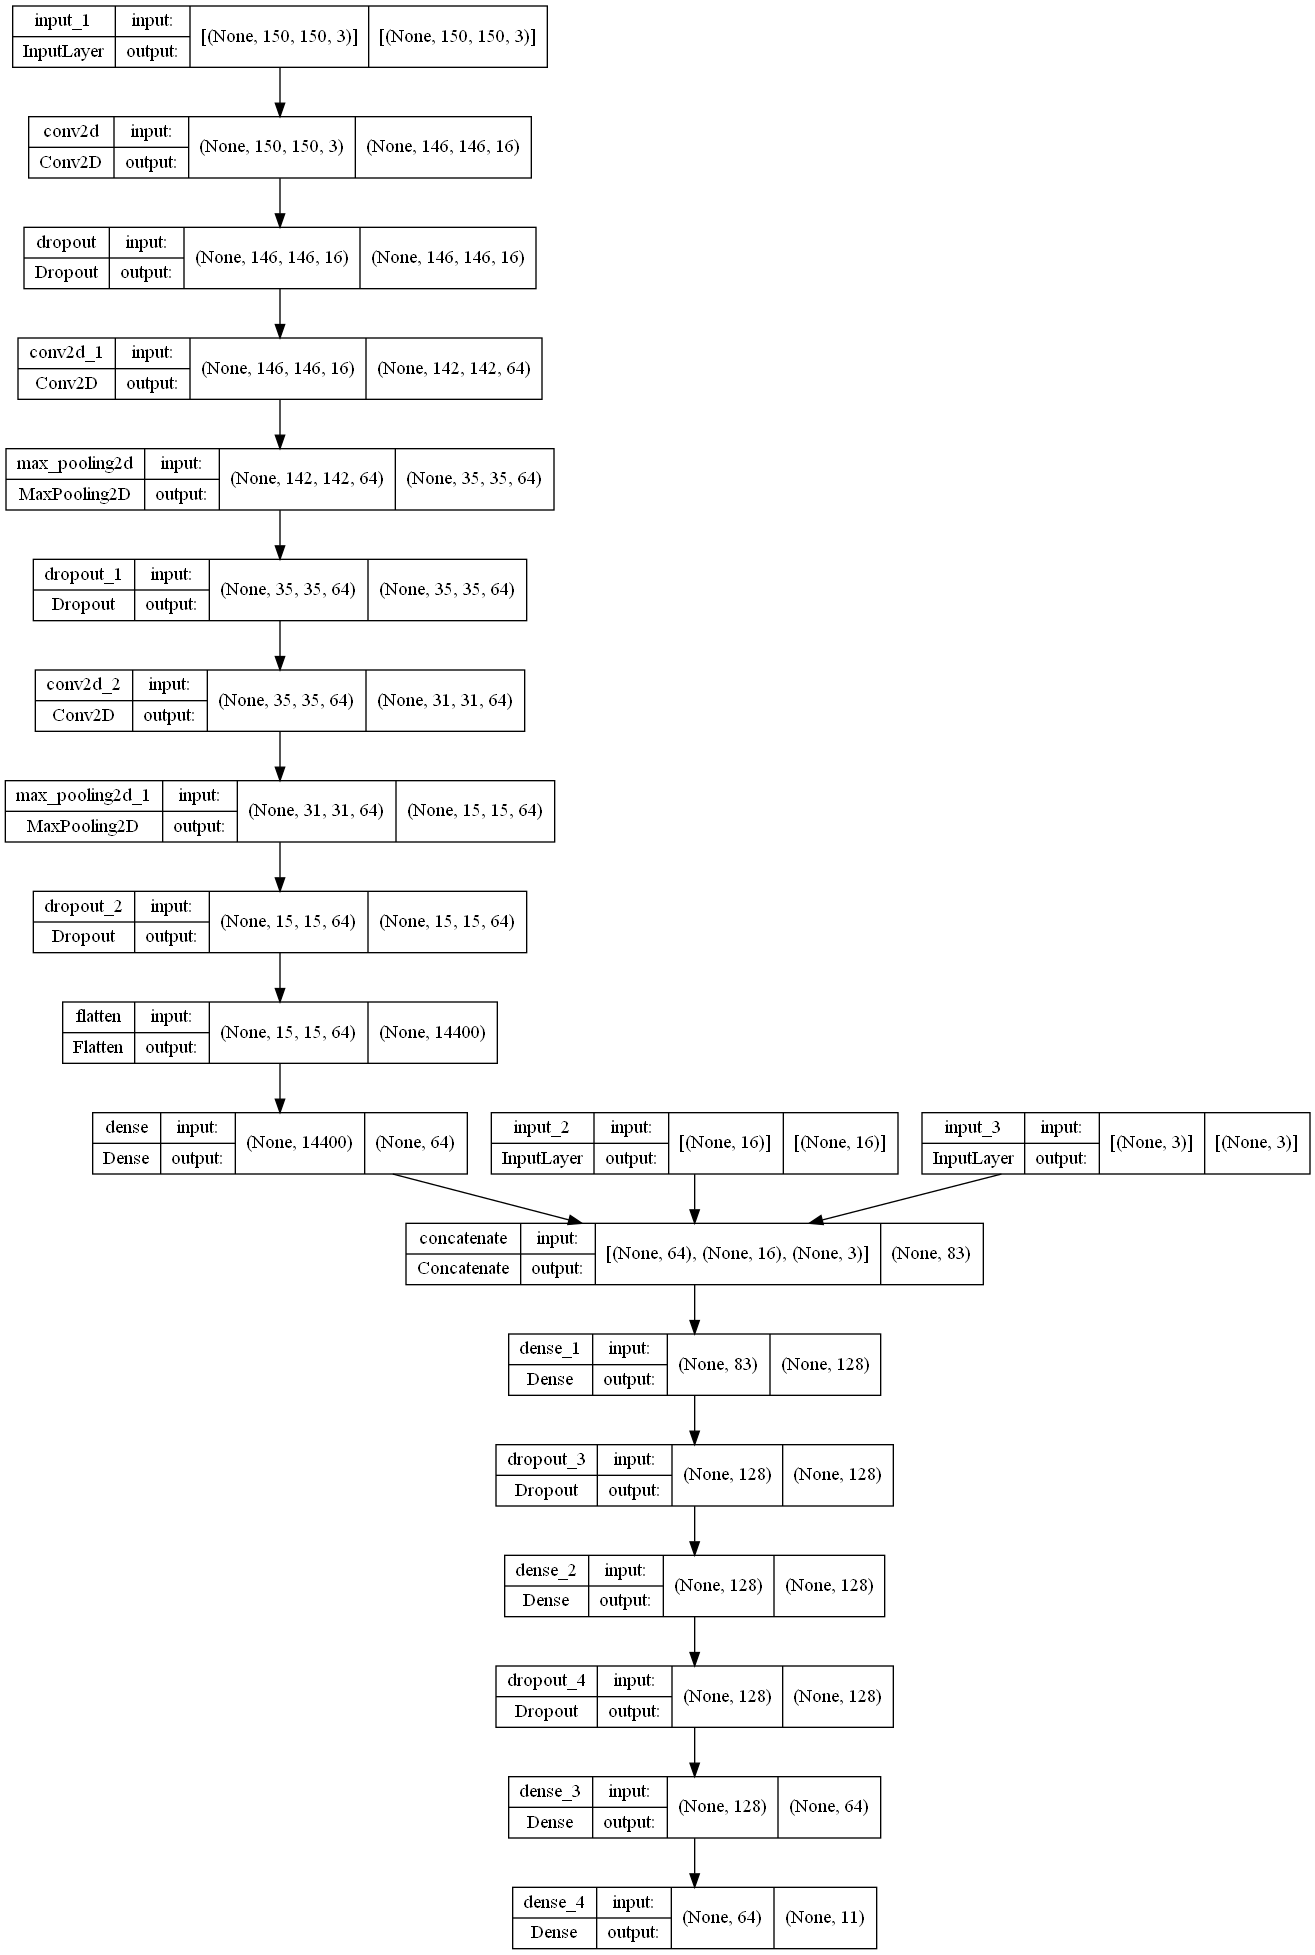

In [17]:
# you can see model summary

tf.keras.utils.plot_model(model, show_shapes=True)

Compiling the Model

In [35]:
from bpmll import bp_mll_loss
import tensorflow as tf
from sklearn.metrics import log_loss, f1_score # not in use right now

# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)


model.compile(loss = 'binary_crossentropy',
              optimizer= 'adam',
              metrics=[tf.compat.v1.losses.log_loss, tf.keras.metrics.Recall()]

              )

# model.compile(loss = tf.nn.softmax_cross_entropy_with_logits,
#               optimizer= optimizer,
#               metrics=['CategoricalCrossentropy', 'accuracy'])

In [19]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=123)
fac_input_s = sklearn.utils.shuffle(fac_input, random_state=123)
clr_input_s = sklearn.utils.shuffle(clr_input, random_state=123)
y_out_s = sklearn.utils.shuffle(y_out, random_state=123)

weigh = np.array([1/42, 1/89, 1/112, 1/370, 1/135, 1/250, 1/47, 1/347, 1/51, 1/230, 1/50])
weigh = weigh * 1205 / 11
cw = {0:weigh[0], 1:weigh[1], 2:weigh[2], 3:weigh[3], 4:weigh[4], 5:weigh[5], 6:weigh[6], 7:weigh[7], 8:weigh[8], 9:weigh[9], 10:weigh[10]}

In [36]:
with tf.device("/device:GPU:0"):
  history = model.fit(
  x=[img_arr_s,fac_input_s, clr_input_s],
  y=y_out_s,
  validation_split=0.2,
  epochs=50,
  callbacks=[lr_scheduler],
  #class_weight = cw,
  batch_size=32
)

Epoch 1/50
31/31 [==============================] - 3s 60ms/step - loss: 0.4069 - log_loss: 0.4060 - recall_2: 0.0726 - val_loss: 0.3664 - val_log_loss: 0.3668 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - 2s 50ms/step - loss: 0.3600 - log_loss: 0.3628 - recall_2: 0.0065 - val_loss: 0.3864 - val_log_loss: 0.3870 - val_recall_2: 0.0091 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - 2s 53ms/step - loss: 0.3493 - log_loss: 0.3474 - recall_2: 0.0194 - val_loss: 0.3758 - val_log_loss: 0.3770 - val_recall_2: 0.0242 - lr: 0.0010
Epoch 4/50
31/31 [==============================] - 1s 47ms/step - loss: 0.3432 - log_loss: 0.3446 - recall_2: 0.0345 - val_loss: 0.3549 - val_log_loss: 0.3566 - val_recall_2: 0.0393 - lr: 0.0010
Epoch 5/50
31/31 [==============================] - 1s 44ms/step - loss: 0.3387 - log_loss: 0.3383 - recall_2: 0.0596 - val_loss: 0.3530 - val_log_loss: 0.3547 - val_recall_2: 0.0755 - lr: 0.0010
Epoch 6/50
31/31

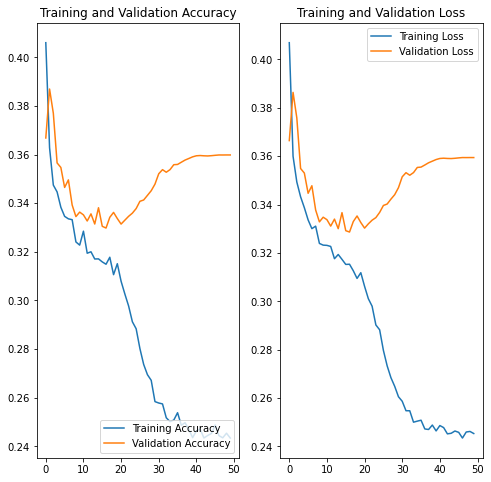

In [37]:
import matplotlib.pyplot as plt

acc = history.history['log_loss']
val_acc = history.history['val_log_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
model.predict([img_arr_s[140:143],fac_input_s[140:143], clr_input_s[140:143]])

array([[0.03798402, 0.09661555, 0.17454253, 0.11045736, 0.00209959,
        0.3788412 , 0.05897285, 0.46697298, 0.02340755, 0.14772575,
        0.02461894],
       [0.02011349, 0.12476646, 0.04792115, 0.7243762 , 0.06450181,
        0.2294597 , 0.01116028, 0.30781823, 0.02436521, 0.04053913,
        0.03792468],
       [0.05146856, 0.32211176, 0.20902316, 0.11130161, 0.03032065,
        0.09892844, 0.0231464 , 0.4185118 , 0.04111525, 0.3809475 ,
        0.09148878]], dtype=float32)

In [39]:
y_out_s[140:143]

array([[0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [24]:
for genre in y_data.columns:
    print(genre, ': ', len(y_data[y_data[genre] == 1]))

Blues :  42
Electronic :  89
Folk, World, & Country :  112
Funk&Soul :  370
Hip Hop :  135
Jazz :  250
Latin :  47
Pop :  347
Reggae :  51
Rock :  230
Stage & Screen :  50


In [25]:
import numpy as np

a = np.array([0.19068299, 0.38264576, 0.5112294 , 0.91950315, 0.6525794 , 0.7625765 , 0.18932, 0.8939849 , 0.31639096, 0.84405494, 0.17323612])

In [94]:
import tensorflow as tf

b = tf.round(asdf)

In [26]:
asdf

array([[0.05662136, 0.16607894, 0.18742241, 0.37353346, 0.14911813,
        0.28890982, 0.11232238, 0.39391008, 0.14130892, 0.29082528,
        0.12739693],
       [0.14905626, 0.17031601, 0.20042908, 0.38828355, 0.25353763,
        0.3042009 , 0.15369332, 0.34080786, 0.16111292, 0.3143366 ,
        0.20126592],
       [0.04779759, 0.12222886, 0.19187751, 0.35770586, 0.17011602,
        0.24943049, 0.11327174, 0.3911908 , 0.12177941, 0.26476833,
        0.10248082]], dtype=float32)

In [96]:
def round_up(a):
    if a - int(a) >= 0.8:
        return int(a) + 1
    return int(a)

In [31]:
model.predict([img_arr_s[360:363],fac_input_s[360:363], clr_input_s[360:363]]) > 0.3

array([[False, False, False,  True, False, False, False,  True, False,
        False, False],
       [False, False,  True,  True,  True,  True, False,  True,  True,
         True,  True],
       [False, False, False,  True, False,  True, False,  True, False,
         True, False]])

In [107]:
y_out_s[360:363] > 0.8

array([[False, False, False, False,  True, False, False,  True, False,
        False, False],
       [False, False, False, False, False, False,  True,  True, False,
         True, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False]])

In [ ]:
import sklearn

sklearn.utils.class_weight.compute_class_weight()